In this tutorial we explain we show how to use the `ShuffleImportanceExplainer` to obtain feature importances of our model. This explainer estimates the feature importances by randomly shuffling one feature at a time and, on each step, checking how much a particular metric worses. In this way the features which make the model to perform the worst are the most important ones.

This method can be used in a given black-box model. In this tutorial, we will use it with a neural network model.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

## Load Dataset

We will use the default credit card Dataset from the UCI machine learning repository. The dataset was used in [1]

In [2]:
path_dataset = "./data/credit/"
uci_credit = pd.read_csv(path_dataset + "UCI_Credit_card.csv")
uci_credit = uci_credit.drop('ID', axis=1)

uci_credit["SEX"] = uci_credit["SEX"].astype(str)
uci_credit["EDUCATION"] = uci_credit["EDUCATION"].astype(str)
uci_credit["MARRIAGE"] = uci_credit["MARRIAGE"].astype(str)

In [3]:
df_train, df_test = train_test_split(uci_credit, test_size=0.3, random_state=2000)
print(df_train.shape)
print(df_test.shape)

(21000, 24)
(9000, 24)


In [4]:
df_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
15639,270000.0,2,2,1,32,2,0,0,0,0,...,275560.0,243792.0,251098.0,11000.0,12000.0,11000.0,8700.0,11077.0,34000.0,0
29049,500000.0,2,3,1,54,-2,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5872,80000.0,2,3,2,30,0,0,0,-1,0,...,28698.0,29299.0,30120.0,2165.0,2774.0,30458.0,1063.0,1308.0,4317.0,0
442,30000.0,2,1,2,26,1,-2,-1,-1,-1,...,0.0,197.0,2995.0,0.0,945.0,0.0,197.0,2995.0,0.0,0
19499,360000.0,2,1,2,27,1,-2,-2,-2,-2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Let's see the correlation of the features with the target

In [5]:
pay_feats = [c for c in df_train.columns if "PAY_" in c]
bill_feats = [c for c in df_train.columns if "BILL_" in c]
num_feats = ['LIMIT_BAL', 'AGE'] + pay_feats + bill_feats

cat_feats = ['SEX', 'EDUCATION', 'MARRIAGE']

label_col = "default.payment.next.month"

In [6]:
df_train.corr()[label_col].sort_values()

<ipython-input-6-940cd4f2efd5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train.corr()[label_col].sort_values()


LIMIT_BAL                    -0.146815
PAY_AMT1                     -0.073130
PAY_AMT3                     -0.061078
PAY_AMT2                     -0.057215
PAY_AMT4                     -0.057146
PAY_AMT5                     -0.055810
PAY_AMT6                     -0.051625
BILL_AMT1                    -0.021519
BILL_AMT2                    -0.017002
BILL_AMT3                    -0.016573
BILL_AMT4                    -0.013658
BILL_AMT5                    -0.008171
BILL_AMT6                    -0.007178
AGE                           0.019424
PAY_6                         0.186807
PAY_5                         0.202506
PAY_4                         0.219943
PAY_3                         0.239534
PAY_2                         0.264153
PAY_0                         0.322071
default.payment.next.month    1.000000
Name: default.payment.next.month, dtype: float64

We see that the feature that has strongest correlation with the target is `PAY_0`

## Preprocess Dataset

Now, let's create a preprocessing pipeline to scale numeric features and perform one-hot encoding to categorical features:

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_feats),
        ("cat", categorical_transformer, cat_feats),
    ], remainder='drop'
)

preprocessing_pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
preprocessing_pipeline = preprocessing_pipeline.fit(df_train)

In [9]:
X_train = preprocessing_pipeline.transform(df_train)
y_train = df_train[label_col].values
X_test = preprocessing_pipeline.transform(df_test)
y_test = df_test[label_col].values

## Train Neural Network

Now let's train our model. We will train a neural network using tf.keras

In [10]:
import tensorflow as tf

def get_model(n_inputs, layer_1, layer_2, layer_3, optimizer, *args, **kwargs):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(layer_1, input_shape=(n_inputs,)))
    model.add(tf.keras.layers.Dense(layer_2))
    model.add(tf.keras.layers.Dense(layer_3))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=optimizer, 
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.Recall()]
    )
    
    return model

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model = get_model(n_inputs=X_train.shape[1], layer_1=20, layer_2=20, layer_3=15, optimizer=optimizer)
hist = model.fit(X_train, y_train, 
  epochs=10, 
  class_weight={0:1, 1:5}, 
  validation_data=(X_test, y_test),
  verbose=0
 )

In [12]:
model.evaluate(X_test, y_test)

282/282 [==============================] - 1s 5ms/step - loss: 0.6978 - recall: 0.7767


[0.6977816224098206, 0.7766749262809753]

## Shuffle Importance Explainer

Let's obtain the feature importance using the `ShuffleImportanceExplainer`. First, we need to create a function that uses our model make the inference and compute a metric. In this case, we compute the log-loss, which lower values means better performance. When using metrics where higher values means better performance it is recommended to return the negative of that metric to make the results more intuitive

In [13]:
def model_inference_function(data, target):
    X = preprocessing_pipeline.transform(data)
    loss, recall = model.evaluate(X, data[target].values, verbose=0)
    return loss

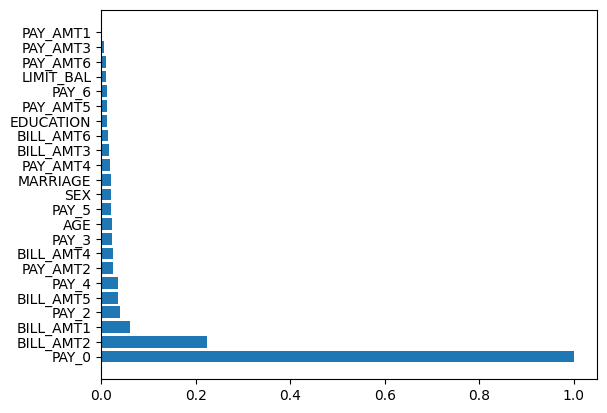

In [14]:
from mercury.explainability.explainers import ShuffleImportanceExplainer

explainer = ShuffleImportanceExplainer(model_inference_function)
explanation = explainer.explain(df_test, target=label_col)
ax = explanation.plot()

We see that the most important feature is `PAY_0`. By default, the `ShuffleImportanceExplainer` normalizes the importances so they will be in the range [0,1]. After the normalization, the feature importances are showing us an approximation of the relative importance of the features. In the example, the feature `PAY_0` is the most important (if you shuffle it, the logloss has the largest increase) and the feature `BILL_AMT2` might have around 20% of the importance of `age`.

It is possible to not perform this normalization. In that case, the feature importances will be the value returned by the `model_inference_function` when shuffling that feature. This is useful when you want to see the impact of shuffling each feature in the metric instead of the relative importances. Let's see an example:

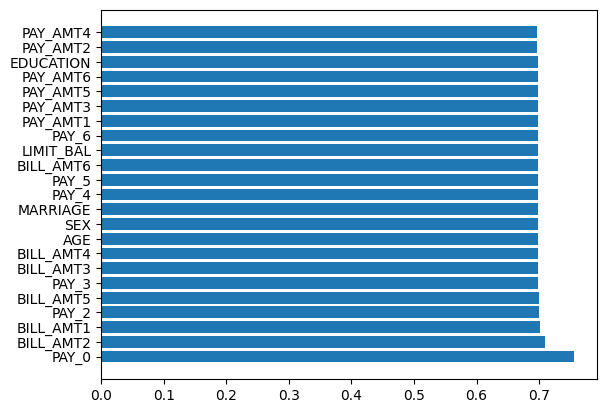

In [15]:
explainer = ShuffleImportanceExplainer(model_inference_function, normalize=False)
explanation = explainer.explain(df_test, target=label_col)
ax = explanation.plot()

In this plot, is difficult to appreciate any differences between features. We can pass the option `limit_axis_x=True` to the `plot()` method in order to make the differences more appreciable:

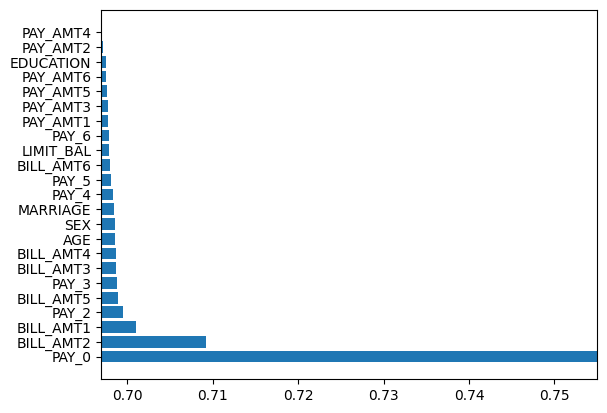

In [16]:
ax = explanation.plot(limit_axis_x=True)

If we look at the x-axis, we get a loss lower than 0.70 when shuffling the feature `PAY_AMT4`, while the loss increases to more than 0.75 when shuffling the feature `PAY_0`
(Note: the exact numbers may change in different executions)

We can also call the `get_importances` method in order to obtain the exact values:

In [17]:
explanation.get_importances()

[('PAY_0', 0.7550156116485596),
 ('BILL_AMT2', 0.7092148065567017),
 ('BILL_AMT1', 0.701025128364563),
 ('PAY_2', 0.6995028257369995),
 ('BILL_AMT5', 0.6989589929580688),
 ('PAY_3', 0.6987423300743103),
 ('BILL_AMT3', 0.698727011680603),
 ('BILL_AMT4', 0.698687732219696),
 ('AGE', 0.6986038088798523),
 ('SEX', 0.6985769271850586),
 ('MARRIAGE', 0.6984201669692993),
 ('PAY_4', 0.698383092880249),
 ('PAY_5', 0.6980672478675842),
 ('BILL_AMT6', 0.6979629993438721),
 ('LIMIT_BAL', 0.6978285312652588),
 ('PAY_6', 0.6977996230125427),
 ('PAY_AMT1', 0.6977673768997192),
 ('PAY_AMT3', 0.6977387070655823),
 ('PAY_AMT5', 0.6975966095924377),
 ('PAY_AMT6', 0.6975542902946472),
 ('EDUCATION', 0.6975104808807373),
 ('PAY_AMT2', 0.6971491575241089),
 ('PAY_AMT4', 0.69694584608078)]

It is also possible to use the `ShuffleImportanceExplainer` with Pyspark models. In that case, you should modify the `model_inference_function` to compute the metric from the pyspark model predictions.

## References

[1] Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480. https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients